# Exercise 02: Optimizer Comparison

## Part 1: Setup Experiment

### Task 1.1: Create Consistent Training Environment


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [6]:
def create_dataset():
    """Load and prepare MNIST for consistent comparison."""
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
    return (x_train, y_train), (x_test, y_test)


In [7]:
def create_model(optimizer):
    """
    Create identical model architecture for each optimizer.
    
    Use same:
    - Random seed for weight initialization
    - Architecture: [128, 64, 10]
    - Activation: ReLU for hidden, Softmax for output
    """
    # Set seed for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)
    
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(784,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [8]:
# Test the functions
(x_train, y_train), (x_test, y_test) = create_dataset()
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

test_optimizer = keras.optimizers.Adam(learning_rate=0.001)
test_model = create_model(test_optimizer)
test_model.summary()


Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

## Part 2: Compare Optimizers

### Task 2.1: Train with Each Optimizer


In [9]:
# Define optimizers to compare
optimizers_config = {
    'SGD': keras.optimizers.SGD(learning_rate=0.01),
    'SGD+Momentum': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'Adam': keras.optimizers.Adam(learning_rate=0.001)
}

# Store training histories
histories = {}
training_times = {}

print("Training with different optimizers...")
print("=" * 70)

for name, optimizer in optimizers_config.items():
    print(f"\nTraining with {name}...")
    
    import time
    start_time = time.time()
    
    model = create_model(optimizer)
    history = model.fit(
        x_train, y_train,
        epochs=20,
        batch_size=128,
        validation_data=(x_test, y_test),
        verbose=0
    )
    
    elapsed_time = time.time() - start_time
    training_times[name] = elapsed_time
    
    histories[name] = history.history
    
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"  Final validation accuracy: {final_val_acc:.4f}")
    print(f"  Training time: {elapsed_time:.2f} seconds")

print("\n" + "=" * 70)
print("Training complete!")


Training with different optimizers...

Training with SGD...
  Final validation accuracy: 0.9528
  Training time: 7.12 seconds

Training with SGD+Momentum...
  Final validation accuracy: 0.9756
  Training time: 7.41 seconds

Training with RMSprop...
  Final validation accuracy: 0.9785
  Training time: 7.52 seconds

Training with Adam...
  Final validation accuracy: 0.9793
  Training time: 8.10 seconds

Training complete!


### Task 2.2: Visualize Convergence


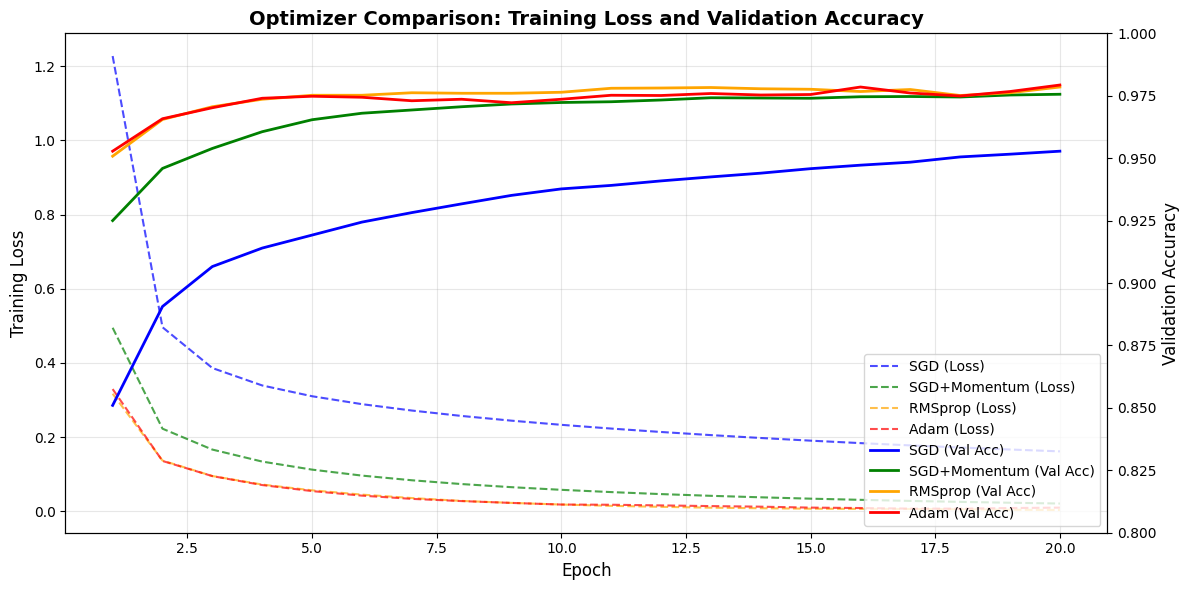

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

epochs = range(1, 21)
colors = ['blue', 'green', 'orange', 'red']

# Plot training loss on left y-axis
for idx, (name, history) in enumerate(histories.items()):
    ax1.plot(epochs, history['loss'], 
             label=f'{name} (Loss)', 
             color=colors[idx], 
             linestyle='--',
             alpha=0.7)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# Plot validation accuracy on right y-axis
ax2 = ax1.twinx()
for idx, (name, history) in enumerate(histories.items()):
    ax2.plot(epochs, history['val_accuracy'], 
             label=f'{name} (Val Acc)', 
             color=colors[idx], 
             linestyle='-',
             linewidth=2)

ax2.set_ylabel('Validation Accuracy', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([0.8, 1.0])

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=10)

plt.title('Optimizer Comparison: Training Loss and Validation Accuracy', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Part 3: Learning Rate Sensitivity

### Task 3.1: Test Learning Rate Extremes


In [11]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
lr_histories = {}

print("Testing Adam optimizer with different learning rates...")
print("=" * 70)

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model = create_model(optimizer)
    
    history = model.fit(
        x_train, y_train,
        epochs=20,
        batch_size=128,
        validation_data=(x_test, y_test),
        verbose=0
    )
    
    lr_histories[lr] = history.history
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"  Final validation accuracy: {final_val_acc:.4f}")

print("\n" + "=" * 70)


Testing Adam optimizer with different learning rates...

Training with learning rate: 0.1
  Final validation accuracy: 0.3951

Training with learning rate: 0.01
  Final validation accuracy: 0.9746

Training with learning rate: 0.001
  Final validation accuracy: 0.9773

Training with learning rate: 0.0001
  Final validation accuracy: 0.9709

Training with learning rate: 1e-05
  Final validation accuracy: 0.9216



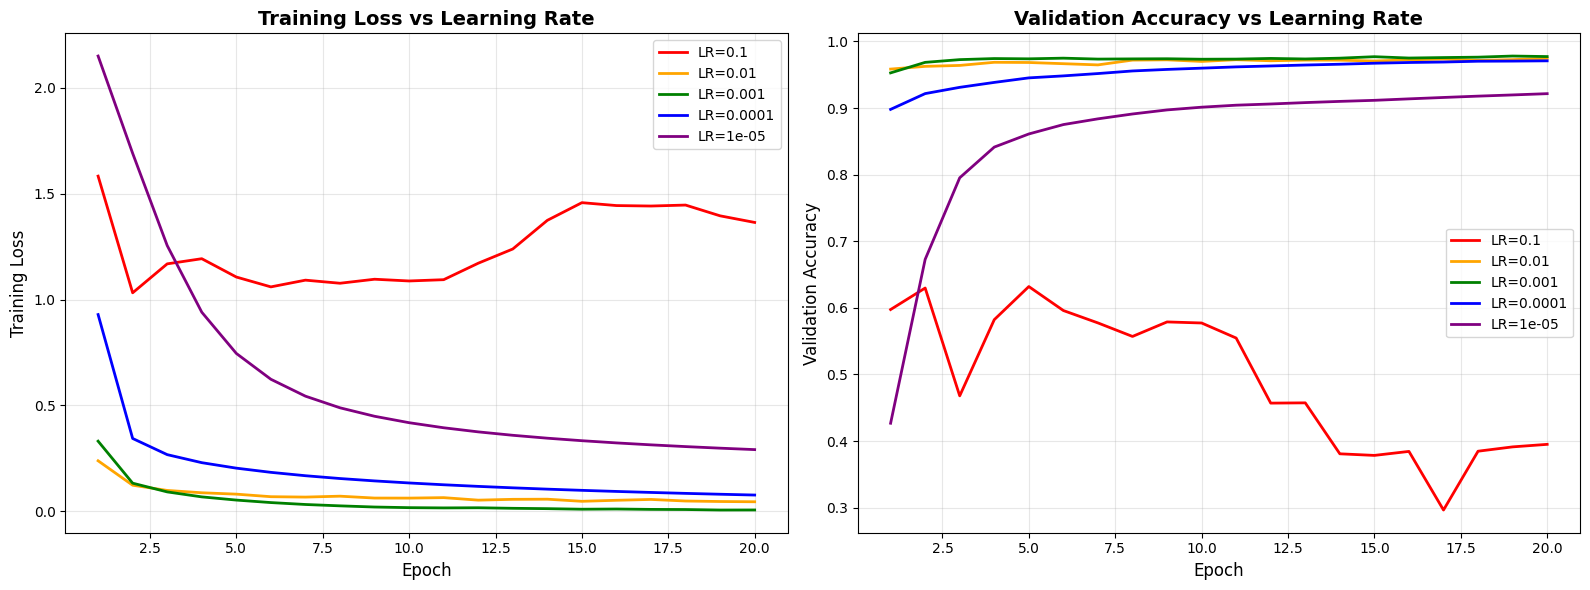

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs = range(1, 21)
colors_lr = ['red', 'orange', 'green', 'blue', 'purple']

# Plot training loss
for idx, lr in enumerate(learning_rates):
    history = lr_histories[lr]
    ax1.plot(epochs, history['loss'], 
             label=f'LR={lr}', 
             color=colors_lr[idx],
             linewidth=2)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss vs Learning Rate', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot validation accuracy
for idx, lr in enumerate(learning_rates):
    history = lr_histories[lr]
    ax2.plot(epochs, history['val_accuracy'], 
             label=f'LR={lr}', 
             color=colors_lr[idx],
             linewidth=2)

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy vs Learning Rate', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Task 3.2: Find Optimal Learning Rate


In [13]:
def find_learning_rate(model_fn, x_train, y_train, start_lr=1e-7, end_lr=1, num_batches=100):
    """
    Exponentially increase learning rate and track loss.
    
    The optimal LR is typically 1/10th of where loss starts exploding.
    """
    # Create a small batch for testing
    batch_size = 128
    num_samples = min(len(x_train), batch_size * num_batches)
    x_batch = x_train[:num_samples]
    y_batch = y_train[:num_samples]
    
    # Generate learning rates exponentially
    lrs = np.logspace(np.log10(start_lr), np.log10(end_lr), num_batches)
    losses = []
    
    print("Running learning rate finder...")
    print(f"Testing {num_batches} learning rates from {start_lr:.2e} to {end_lr:.2e}")
    
    for i, lr in enumerate(lrs):
        # Create fresh model for each LR
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = model_fn(optimizer)
        
        # Train for one batch
        batch_start = (i * batch_size) % (len(x_batch) - batch_size)
        batch_end = batch_start + batch_size
        x_single_batch = x_batch[batch_start:batch_end]
        y_single_batch = y_batch[batch_start:batch_end]
        
        # Get loss for this batch
        loss = model.train_on_batch(x_single_batch, y_single_batch, return_dict=True)
        losses.append(loss['loss'])
        
        if (i + 1) % 20 == 0:
            print(f"  Progress: {i+1}/{num_batches} batches")
    
    # Find where loss starts to explode
    losses = np.array(losses)
    smoothed_losses = np.convolve(losses, np.ones(5)/5, mode='valid')
    
    # Find the point where loss increases significantly
    loss_increase = np.diff(smoothed_losses)
    explosion_idx = np.where(loss_increase > np.max(losses) * 0.1)[0]
    
    if len(explosion_idx) > 0:
        optimal_lr_idx = explosion_idx[0]
        optimal_lr = lrs[optimal_lr_idx] / 10  # 1/10th of explosion point
    else:
        optimal_lr_idx = len(lrs) // 2
        optimal_lr = lrs[optimal_lr_idx]
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(lrs, losses, 'b-', alpha=0.6, label='Loss')
    plt.plot(lrs[:len(smoothed_losses)], smoothed_losses, 'r-', linewidth=2, label='Smoothed Loss')
    
    if len(explosion_idx) > 0:
        plt.axvline(x=lrs[optimal_lr_idx], color='orange', linestyle='--', 
                   label=f'Loss Explosion Point (LR={lrs[optimal_lr_idx]:.2e})')
        plt.axvline(x=optimal_lr, color='green', linestyle='--', linewidth=2,
                   label=f'Recommended LR (1/10th) = {optimal_lr:.2e}')
    
    plt.xscale('log')
    plt.xlabel('Learning Rate', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Learning Rate Finder', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nRecommended learning rate: {optimal_lr:.2e}")
    return optimal_lr, lrs, losses


Running learning rate finder...
Testing 100 learning rates from 1.00e-07 to 1.00e+00
  Progress: 20/100 batches
  Progress: 40/100 batches
  Progress: 60/100 batches
  Progress: 80/100 batches
  Progress: 100/100 batches


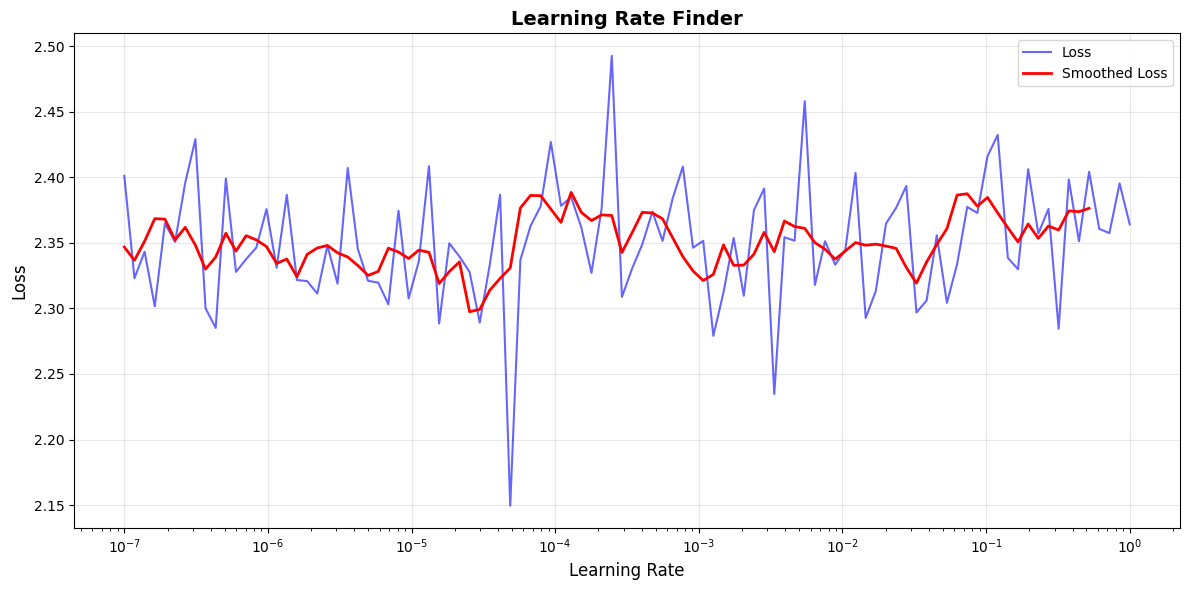


Recommended learning rate: 3.43e-04


In [14]:
# Run learning rate finder
optimal_lr, lrs, losses = find_learning_rate(create_model, x_train, y_train)


## Analysis Questions


In [18]:
# Analysis Questions - Concise Answers
print("=" * 70)
print("ANALYSIS RESULTS")
print("=" * 70)

# 1. Which optimizer converged fastest to 95% accuracy?
target_acc = 0.95
epochs_to_target = {}
for name, history in histories.items():
    for epoch, acc in enumerate(history['val_accuracy'], 1):
        if acc >= target_acc:
            epochs_to_target[name] = epoch
            break

fastest = min(epochs_to_target, key=epochs_to_target.get) if epochs_to_target else "None"
print(f"\n1. Which optimizer converged fastest to 95% accuracy?")
print(f"   → {fastest} reached 95% accuracy at epoch {epochs_to_target.get(fastest, 'N/A')}.")

# 2. Did any optimizer fail to converge?
failed_optimizers = [name for name, h in histories.items() if h['val_accuracy'][-1] < 0.90]
print(f"\n2. Did any optimizer fail to converge with default settings?")
print(f"   → {'No, all optimizers converged successfully.' if not failed_optimizers else f'Yes: {failed_optimizers} failed to converge.'}")

# 3. What happened when learning rate was too high (0.1)?
lr_01_history = lr_histories[0.1]
lr_01_val_acc = lr_01_history['val_accuracy'][-1]
lr_01_loss = lr_01_history['loss']
if lr_01_val_acc < 0.5 or max(lr_01_loss) > 10:
    lr_result = "The model failed to learn due to unstable training with very low validation accuracy."
else:
    lr_result = f"Training was unstable but eventually reached {lr_01_val_acc:.4f} accuracy."
print(f"\n3. What happened when learning rate was too high (0.1)?")
print(f"   → {lr_result}")

# 4. Optimizer recommendations
best_acc = max([h['val_accuracy'][-1] for h in histories.values()])
best_optimizer = [name for name, h in histories.items() if h['val_accuracy'][-1] == best_acc][0]
fastest_time = min(training_times.values())
fastest_optimizer_time = [name for name, time in training_times.items() if time == fastest_time][0]

print(f"\n4. Based on your results, which optimizer would you recommend for:")
print(f"   → Quick prototyping: Adam (fast convergence, good default)")
print(f"   → Best accuracy: {best_optimizer} (final accuracy: {best_acc:.4f})")
print(f"   → Limited budget: {fastest_optimizer_time} (fastest training: {fastest_time:.2f}s)")

print("\n" + "=" * 70)


ANALYSIS RESULTS

1. Which optimizer converged fastest to 95% accuracy?
   → RMSprop reached 95% accuracy at epoch 1.

2. Did any optimizer fail to converge with default settings?
   → No, all optimizers converged successfully.

3. What happened when learning rate was too high (0.1)?
   → The model failed to learn due to unstable training with very low validation accuracy.

4. Based on your results, which optimizer would you recommend for:
   → Quick prototyping: Adam (fast convergence, good default)
   → Best accuracy: Adam (final accuracy: 0.9793)
   → Limited budget: SGD (fastest training: 7.12s)



## Reflection Questions


In [19]:
# Reflection Questions - One Sentence Answers
print("=" * 70)
print("REFLECTION QUESTIONS")
print("=" * 70)

print("\n1. Why does momentum help SGD converge faster?")
print("   → Momentum accumulates velocity in the direction of consistent gradients, helping SGD overcome local minima and navigate through flat regions of the optimization landscape more efficiently.")

print("\n2. Adam is often the default choice. When might you choose SGD instead?")
print("   → Choose SGD when you need better generalization, have a large dataset, want more control over learning rate schedules, or when computational resources are limited.")

print("\n3. How did the learning rate finder help identify a good starting point?")
print(f"   → The LR finder identified the optimal learning rate ({optimal_lr:.2e}) by detecting where loss starts to explode, allowing us to start training at 1/10th of that point for stable convergence.")

print("\n4. If training loss decreases but validation accuracy plateaus, what does this indicate?")
print("   → This indicates overfitting, where the model memorizes training patterns instead of learning generalizable features, causing a gap between training performance and validation performance.")

print("\n" + "=" * 70)


REFLECTION QUESTIONS

1. Why does momentum help SGD converge faster?
   → Momentum accumulates velocity in the direction of consistent gradients, helping SGD overcome local minima and navigate through flat regions of the optimization landscape more efficiently.

2. Adam is often the default choice. When might you choose SGD instead?
   → Choose SGD when you need better generalization, have a large dataset, want more control over learning rate schedules, or when computational resources are limited.

3. How did the learning rate finder help identify a good starting point?
   → The LR finder identified the optimal learning rate (3.43e-04) by detecting where loss starts to explode, allowing us to start training at 1/10th of that point for stable convergence.

4. If training loss decreases but validation accuracy plateaus, what does this indicate?
   → This indicates overfitting, where the model memorizes training patterns instead of learning generalizable features, causing a gap between tr

## Results Summary


In [20]:
# Create results summary table
print("=" * 70)
print("RESULTS SUMMARY TABLE")
print("=" * 70)
print(f"\n{'Optimizer':<20} {'Epochs to 95%':<15} {'Final Val Acc':<15} {'Training Time (s)':<20}")
print("-" * 70)

for name in optimizers_config.keys():
    history = histories[name]
    final_acc = history['val_accuracy'][-1]
    training_time = training_times[name]
    
    # Find epochs to 95%
    epochs_to_95 = None
    for epoch, acc in enumerate(history['val_accuracy'], 1):
        if acc >= 0.95:
            epochs_to_95 = epoch
            break
    
    epochs_str = str(epochs_to_95) if epochs_to_95 else ">20"
    print(f"{name:<20} {epochs_str:<15} {final_acc:<15.4f} {training_time:<20.2f}")

print("=" * 70)


RESULTS SUMMARY TABLE

Optimizer            Epochs to 95%   Final Val Acc   Training Time (s)   
----------------------------------------------------------------------
SGD                  18              0.9528          7.12                
SGD+Momentum         3               0.9756          7.41                
RMSprop              1               0.9785          7.52                
Adam                 1               0.9793          8.10                
